In [1]:
from utils.general_utils import *
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from utils.plot_utils import *
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

In [2]:
df = pd.read_csv('data/marvel_demo_stats_powers.csv')
df = df.replace('-', 'no_value')

In [3]:
# Create a class out of the alignment column (is good or evil)
df['class'] = df['Alignment_x'].apply(lambda x: True if x == 'good' else False)
df['is_human'] = df['Race'].apply(lambda x: True if 'Human' in x else False)
df.drop(['Unnamed: 0', 'ID', 'Name', 'Alignment_x', 'Publisher'], axis=1, inplace=True)
cols = list(df.columns)
cat_cols = ['Gender', 'EyeColor', 'Race', 'HairColor', 'SkinColor']
int_cols = ['Height', 'Weight', 'Intelligence_x', 'Strength', 'Stamina', 'Speed', 'Durability_x', 'Power', 'Combat', 'Total']
bool_cols = [x for x in cols if (x not in cat_cols and x not in int_cols)]
df[cat_cols] = df[cat_cols].fillna(value='no_value')
df[int_cols] = df[int_cols].fillna(value=0)
df[bool_cols] = df[bool_cols].fillna(value=False)
top_50_features = ['Gender', 'HairColor', 'Race', 'Super Strength', 'EyeColor', 'Stealth', 'Durability_x',
                   'Strength',
                   'Height',
                   'Weight',
                   'Combat',
                   'Total',
                   'Enhanced Senses',
                   'Flight',
                   'Energy Blasts',
                   'Speed',
                   'Stamina',
                   'Energy Absorption',
                   'Power',
                   'Shapeshifting',
                   'Accelerated Healing',
                   'Force Fields',
                   'Psionic Powers',
                   'Weapon-based Powers',
                   'Intelligence_x',
                   'Energy Manipulation',
                   'Reflexes',
                   'Molecular Manipulation',
                   'Durability_y',
                   'Fire Resistance',
                   'is_human',
                   'Agility',
                   'Longevity',
                   'Super Speed',
                   'Invulnerability',
                   'Intelligence_y',
                   'Toxin and Disease Resistance',
                   'Marksmanship',
                   'Heat Resistance',
                   'Natural Weapons',
                   'Enhanced Hearing',
                   'Animal Oriented Powers',
                   'Weapons Master',
                   'Teleportation']
df

,Gender,EyeColor,Race,HairColor,SkinColor,Height,Weight,Intelligence_x,Strength,Speed,...,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient,class,is_human
0,Male,yellow,Human,No Hair,no_value,203.0,441.0,38.0,100.0,17.0,...,False,False,False,False,False,False,False,False,True,True
1,Male,green,Human / Radiation,No Hair,no_value,203.0,441.0,63.0,80.0,53.0,...,False,False,False,False,False,False,False,False,False,True
2,Male,blue,Cosmic Entity,Black,no_value,-99.0,-99.0,88.0,100.0,83.0,...,False,False,False,False,False,False,False,False,False,False
3,Male,blue,Human,No Hair,no_value,193.0,122.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
4,Female,blue,no_value,Blond,no_value,173.0,61.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,Male,blue,no_value,Brown,no_value,175.0,61.0,88.0,53.0,53.0,...,False,False,False,False,False,False,False,False,True,False
378,Male,blue,no_value,No Hair,no_value,188.0,95.0,1.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
379,Male,blue,Human,Blond,no_value,183.0,83.0,88.0,10.0,12.0,...,False,False,False,False,False,False,False,False,True,True
380,Female,blue,Human,Strawberry Blond,no_value,165.0,52.0,50.0,10.0,35.0,...,False,False,False,False,False,False,False,False,True,True


In [4]:
# cast int cols to int type
for col in int_cols:
    df[col] = df[col].astype(int)
# for col in bool_cols:
#     df[col] = df[col].astype(bool)

In [5]:
df = df.reset_index()
X, y = df.drop(['index', 'class'], axis=1), df['class']
X = X.loc[:, top_50_features]

In [6]:
# Model init
cbc = CatBoostClassifier(cat_features=get_cat_feature_names(X), auto_class_weights='Balanced', random_state=5,
                         bootstrap_type='Bayesian', rsm=0.1)
evaluation = Evaluation()

Learning rate set to 0.006524
0:	learn: 0.6921064	total: 52.3ms	remaining: 52.2s
1:	learn: 0.6912157	total: 54.1ms	remaining: 27s
2:	learn: 0.6910965	total: 55.4ms	remaining: 18.4s
3:	learn: 0.6902484	total: 57.4ms	remaining: 14.3s
4:	learn: 0.6889738	total: 59.7ms	remaining: 11.9s
5:	learn: 0.6883609	total: 61.9ms	remaining: 10.3s
6:	learn: 0.6868122	total: 63.6ms	remaining: 9.02s
7:	learn: 0.6860060	total: 65.4ms	remaining: 8.11s
8:	learn: 0.6853485	total: 67.3ms	remaining: 7.42s
9:	learn: 0.6845931	total: 69.1ms	remaining: 6.84s
10:	learn: 0.6837212	total: 70.8ms	remaining: 6.37s
11:	learn: 0.6828717	total: 72.6ms	remaining: 5.97s
12:	learn: 0.6819630	total: 74.3ms	remaining: 5.64s
13:	learn: 0.6810419	total: 75.9ms	remaining: 5.34s
14:	learn: 0.6802525	total: 77.3ms	remaining: 5.08s
15:	learn: 0.6796355	total: 79.1ms	remaining: 4.86s
16:	learn: 0.6791200	total: 81ms	remaining: 4.68s
17:	learn: 0.6783451	total: 83.1ms	remaining: 4.53s
18:	learn: 0.6772811	total: 84.9ms	remaining: 4.

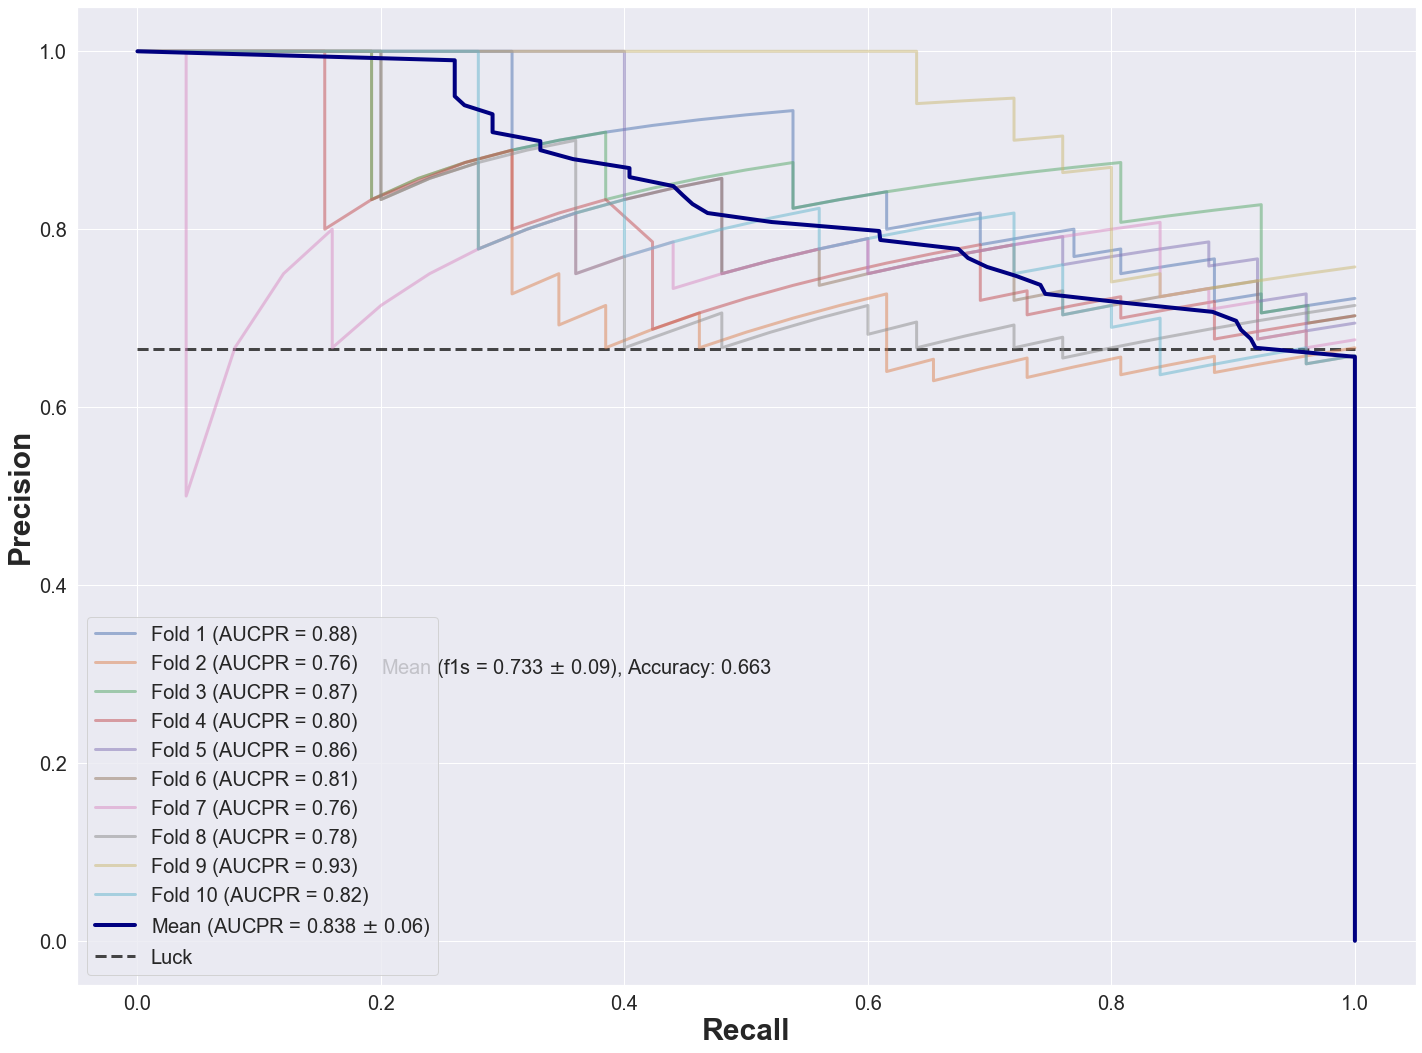

In [7]:
feature_importance = evaluation.plot_cv_precision_recall(cbc, n_folds=10, n_repeats=1, X=X, y=y, random_state=0)

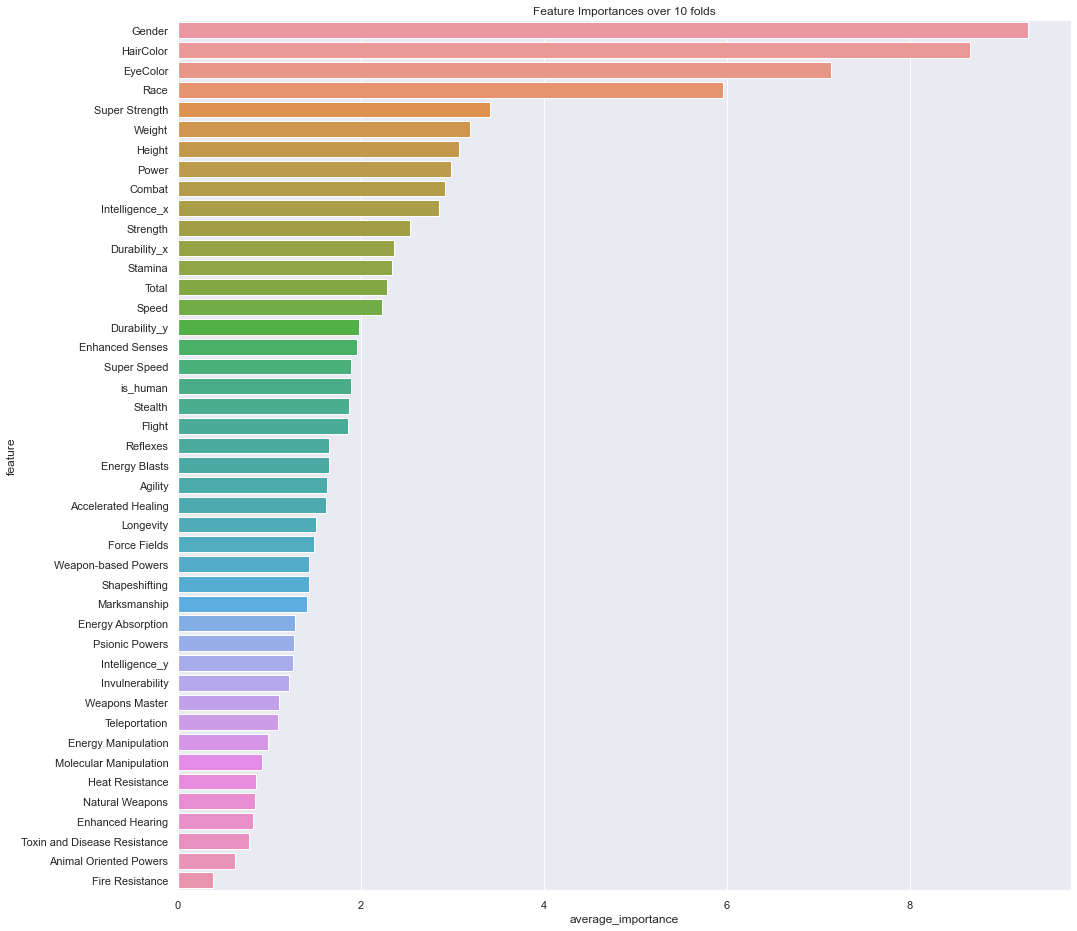

In [8]:
evaluation.plot_feature_importance(feature_importance, n_features_to_show=50)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
cbc.fit(X_train, y_train)
explainer = ClassifierExplainer(cbc, X_test, y_test)
ExplainerDashboard(explainer, simple=True).run()

Learning rate set to 0.00549
0:	learn: 0.6918486	total: 1.9ms	remaining: 1.9s
1:	learn: 0.6910404	total: 5.97ms	remaining: 2.98s
2:	learn: 0.6907583	total: 8.71ms	remaining: 2.89s
3:	learn: 0.6901649	total: 12ms	remaining: 2.98s
4:	learn: 0.6891653	total: 16.9ms	remaining: 3.36s
5:	learn: 0.6882776	total: 20.2ms	remaining: 3.35s
6:	learn: 0.6878011	total: 22.6ms	remaining: 3.2s
7:	learn: 0.6867560	total: 24.8ms	remaining: 3.07s
8:	learn: 0.6862439	total: 26.7ms	remaining: 2.94s
9:	learn: 0.6854571	total: 30.3ms	remaining: 3s
10:	learn: 0.6843740	total: 32.5ms	remaining: 2.93s
11:	learn: 0.6834133	total: 34.9ms	remaining: 2.87s
12:	learn: 0.6820814	total: 37.8ms	remaining: 2.87s
13:	learn: 0.6813208	total: 42ms	remaining: 2.96s
14:	learn: 0.6805479	total: 45ms	remaining: 2.95s
15:	learn: 0.6800669	total: 46.8ms	remaining: 2.88s
16:	learn: 0.6791374	total: 48.6ms	remaining: 2.81s
17:	learn: 0.6780228	total: 52ms	remaining: 2.84s
18:	learn: 0.6769153	total: 55.4ms	remaining: 2.86s
19:	lea

 * Running on all addresses.
 * Running on http://100.64.0.1:8050/ (Press CTRL+C to quit)
